# Robotics Assessment 2

## Student Info

**Student ID Number:** 201663463<br>
**Name:** Haseeb Akbar<br>
**Email:** od21h2a@leeds.ac.uk

###  Summary and Introduction (3) 
Need to create three trainable robot navigation models for this task. Your robot models will navigate in an indoor environment without hitting the walls to reach a goal destination near one of the pillars in the environment. 


command to run: roslaunch turtlebot3_gazebo turtlebot3_assessment2.launch

### ENV Class
Creating a suitable Env class that communicates with the provided environment and isolates the ROS requirements from the RL solution (10)

### Robot model 1: Tabular Solution

Use a tabular RL method (2)
Correctly divide the environment into a grid and use odometry only for state representation (2)
Use a suitable reward function (2)
Parameters tuning and justification (2) 
Learning plots, model’s success rate (2)
Analysis of the results (2) 

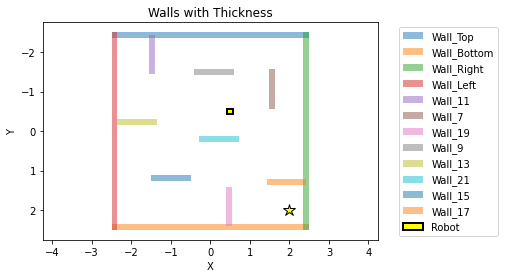

In [74]:
import matplotlib.pyplot as plt

walls = {
       "Wall_Top": {"left_x": 2.5, "right_x": -2.5, "bottom_y": -2.35, "top_y": -2.5},
       "Wall_Bottom": {"left_x": 2.5, "right_x": -2.5, "bottom_y": 2.5, "top_y": 2.35},
       "Wall_Right": {"left_x": 2.5, "right_x": 2.35, "bottom_y": 2.5, "top_y": -2.5},
       "Wall_Left": {"left_x": -2.5, "right_x": -2.35, "bottom_y": 2.5, "top_y": -2.5},
        ## Verticals
       "Wall_11": {"left_x": -1.392, "right_x": -1.542, "bottom_y": -1.437, "top_y": -2.437},
       "Wall_7": {"left_x": 1.623, "right_x": 1.473, "bottom_y": -0.564, "top_y": -1.564},
       "Wall_19": {"left_x": 0.5382, "right_x": 0.3882, "bottom_y": 2.41128, "top_y": 1.41128},
       ## Horizontals
       "Wall_9":{"left_x": 0.592, "right_x": -0.408, "bottom_y": -1.427, "top_y": -1.577},
       "Wall_13":{"left_x": -1.36, "right_x": -2.36, "bottom_y": -0.145, "top_y": -0.295},
       "Wall_21":{"left_x": 0.715, "right_x": -0.285, "bottom_y": 0.279, "top_y": 0.129},
       "Wall_15":{"left_x": -0.502, "right_x": -1.502, "bottom_y": 1.27, "top_y": 1.12},
       "Wall_17":{"left_x": 2.43, "right_x": 1.43, "bottom_y": 1.363, "top_y": 1.213},
}

robot = {
       "Robot":{"left_x": 0.43017, "right_x":0.57017 , "bottom_y": -0.570048, "top_y": -0.430048},
}

goals = {
    "Goal1":{"left_x": -2.125, "right_x":-1.875, "bottom_y": -2.125, "top_y": -1.875},
    "Goal1":{"left_x": 1.875, "right_x":2.125, "bottom_y": 1.875, "top_y": 2.125},
}

fig, ax = plt.subplots()

# Draw the walls
for wall, coords in walls.items():
    ax.fill([coords["left_x"], coords["right_x"], coords["right_x"], coords["left_x"]],
            [coords["bottom_y"], coords["bottom_y"], coords["top_y"], coords["top_y"]],
            label=wall, alpha=0.5)

# Draw the robot
for r, robot_coords in robot.items():
    ax.fill([robot_coords["left_x"], robot_coords["right_x"], robot_coords["right_x"], robot_coords["left_x"]],
            [robot_coords["bottom_y"], robot_coords["bottom_y"], robot_coords["top_y"], robot_coords["top_y"]],
            label=r, alpha=1, color="yellow", linewidth=2, linestyle="-", edgecolor="black")
    
# Draw the goals
for g, goal_coords in goals.items():
    ax.plot((goal_coords["left_x"] + goal_coords["right_x"])/2, (goal_coords["bottom_y"] + goal_coords["top_y"])/2,
            marker="*", markersize=12, markerfacecolor="yellow", markeredgecolor="black")
    
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Walls with Thickness")
plt.axis("equal")

# Invert the y-axis
ax.invert_yaxis()

plt.show()
